In [1]:
#Configure Kaggle on Colab and import the data
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ghitaaitouhmane","key":"d46ea03dd9039fc5658857a5ce8dd741"}'}

In [ ]:
#Run twice
! mkdir /.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
#The dataset
! kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign
! unzip skin-cancer-malignant-vs-benign.zip

In [4]:
#Importing required libraries
%matplotlib inline

import os
import gc
from PIL import Image

import matplotlib.pyplot as plt
from skimage.io import imread,imsave,imshow

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras.applications import VGG16
import tensorflow
from sklearn.utils import check_random_state

from keras.callbacks import ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam, RMSprop
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from keras import backend as K 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_confusion_matrix


sns.set()
np.random.seed(0);
tensorflow.random.set_seed(0);
check_random_state(0);

(224, 224, 3)


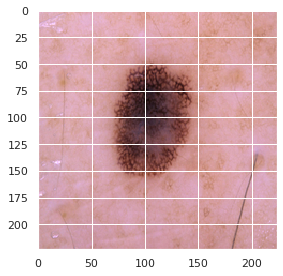

In [5]:
#The data is already divided into training and testing tests in corresponding labeled folders
#Looking at the format of the images 

im=imread("/content/train/benign/100.jpg")
print(im.shape)
imshow(im)
#According to the desciption of the dataset, all images are of size 224x224, so there will be no need to resize them as a preprocessing

##Constructing the dataset

In [6]:
#Constructing the lists containing the training and testing data paths and corresponding labels
training_img, testing_img = [], []
training_labels, testing_labels = [], []

#We encode a benign mole with a value 0 and a malignant one with 1

#Constructing the training data paths
for img_path in os.listdir('/content/data/train/benign'):
    training_img.append('/content/data/train/benign/' + img_path)
    training_labels.append(0)

for img_path in os.listdir('/content/data/train/malignant'):
    training_img.append('/content/data/train/malignant/' + img_path)
    training_labels.append(1)
    
for img_path in os.listdir('/content/data/test/benign'):
    testing_img.append('/content/data/test/benign/' + img_path)
    testing_labels.append(0)
    
for img_path in os.listdir('/content/data/test/malignant'):
    testing_img.append('/content/data/test/malignant/' + img_path)
    testing_labels.append(1)
   
#Verify that evrything has been set correctly
(len(training_img),len(training_labels),len(testing_img),len(testing_labels))

(2637, 2637, 660, 660)

In [7]:
#We can see that the testing set represents around 20% of the total dataset 
#Is the problem balanced ? 
np.bincount(np.concatenate([training_labels, testing_labels]))
#It is not eaxclty 50-50%, but we can say that the problem is balanced enough

array([1800, 1497])

In [8]:
#We now load the actual images into lists
xtrain, xtest = [], [] #those are the images 
ytrain, ytest = np.array(training_labels), np.array(testing_labels) #those are the labels 1-0

for filename in tqdm.tqdm(training_img):
    xtrain.append(np.array(Image.open(filename)))
    
for filename in tqdm.tqdm(testing_img):
    xtest.append(np.array(Image.open(filename)))
    
#Transforming the lists into numpy arrays
xtrain, xtest = np.array(xtrain), np.array(xtest)

100%|██████████| 660/660 [00:01<00:00, 530.44it/s]


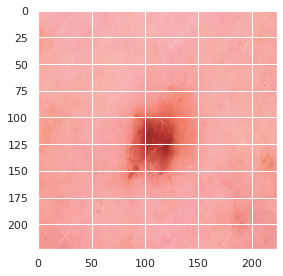

In [9]:
#Verifying if images show correctly 
imshow(xtrain[150])

In [10]:
#Normalizing the data
print(xtrain.dtype)
#Since we are dealing with unsigned 8 bit values, so a range going from 0 to 255, we will divivde the pixel values by 255
xtrain = xtrain.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.

print('Training data shape:', xtrain.shape)
print('Min value:', xtrain.min())
print('Max value:', xtrain.max())

uint8
Training data shape: (2637, 224, 224, 3)
Min value: 0.0
Max value: 1.0


##First model

In [12]:
#Building the first model
#We are dealing with a classification problem, so we will use the most popular type of neural networks to deal with it : CNNs
#For this model we will be doing transfer learning, using the VGG16 which is a CNN that has been pre trained on the ImageNet dataset
def build():
  model = Sequential()
  #include_top=false ignores the classification block so that LeakyReLU layers can be added in between
  model.add(VGG16(include_top=False, input_shape=(224, 224, 3,)))

  #The classification block(FC)
  model.add(Flatten())
  model.add(Dense(32))
  model.add(LeakyReLU(0.001))
  model.add(Dense(16))
  model.add(LeakyReLU(0.001))
  model.add(Dense(1, activation='sigmoid'))
  model.layers[0].trainable = False

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [13]:
#Building and training the first model
model1 = build()
model1.summary()
history1= model1.fit(xtrain, ytrain,validation_split=0.2, epochs=20, batch_size=64, verbose=1)
print(history1.history.keys())

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                802848    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
_________________________________________________________

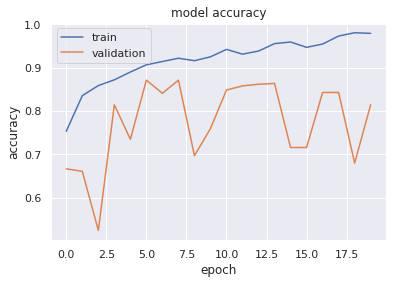

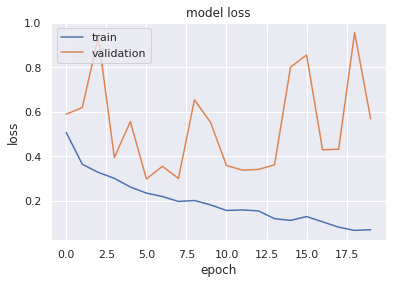

In [14]:
# Ploting the evaluation of accuracy and loss as a function of the number of epochs for training and validation steps
#accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
#loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
#Cross validation 
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(xtrain, ytrain):
  # create model
    model = build()
    
    # Fit the model 
    #dont do validation split here since we evaluate it right after
    model.fit(xtrain[train], ytrain[train], epochs=20, batch_size=64, verbose=0)
    # evaluate the model
    scores = model.evaluate(xtrain[test], ytrain[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


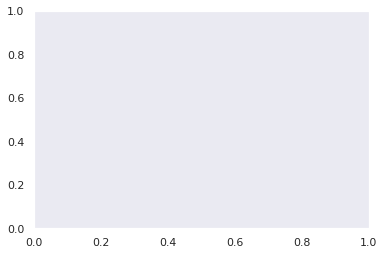

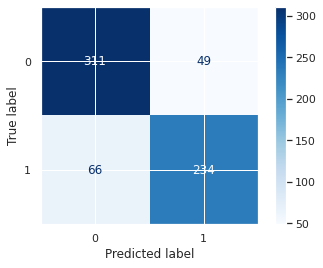

In [16]:
#Confusion matrix for the first model
ypred1 = model1.predict_classes(xtest)
disp=ConfusionMatrixDisplay(confusion_matrix(ytest,ypred1),display_labels= np.array([0,1]))
plt.grid(False) 
disp.plot(cmap='Blues',values_format='',) 

In [ ]:
#Accuracy on the test set
print(accuracy_score(ytest,ypred1))


model_json = model1.to_json()
with open("modelCNN.json", "w") as json_file:
    json_file.write(model_json)    
# serialize weights to HDF5
model1.save_weights("modelCNN.h5")
print("Saved model CNN to disk")

In [ ]:
from google.colab import files
files.download('modelCNN.h5') 
files.download('modelCNN.json') 

##Model 2

In [ ]:
#########################model2
#This maybe is because your neural network is initialised with random values of gains or weights, then you'd have different starting points per each simulation during the training phase.
# To have always the same result, try to propose a fixed seed for the initial weights. 


def build2(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)

In [ ]:
#model2

ytrain = to_categorical(ytrain, num_classes= 2)
ytest = to_categorical(ytest, num_classes= 2)
X_train = xtrain/255.
X_test = xtest/255.
ytrain


In [ ]:

#model2
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50
batch_size = 64
model2 = build2(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)
history2 = model2.fit(xtrain, ytrain, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )


In [ ]:
#on model2 !!!!!!!!!!!!!!!!!!!!!!!!!!!!
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ypred2 = model2.predict_classes(xtest)
print(accuracy_score(np.argmax(ytest, axis=1),ypred2))

In [ ]:
xtrain

In [ ]:
K.clear_session()
del model2
del history

#CROSS VALIDATION ON MODEL2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from keras import backend as K 

# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []
for train, test in kfold.split(xtrain, ytrain):
  # create model
    model2 = build2()
    
    # Fit the model 
    #dont do validation split here since we validate right after
    model2.fit(xtrain[train], ytrain[train], epochs=50, batch_size=64, verbose=0)
    # evaluate the model
    scores = model2.evaluate(xtrain[test], ytrain[test], verbose=0)
    print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model2
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

In [ ]:
#here will do conf matrix for model 2 !!

#model2 = build2(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)
'''
history = model2.fit(xtrain, ytrain, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=1, 
                    callbacks=[learning_rate_reduction]
                   )
'''
ypred2 = model2.predict_classes(xtest)
print(accuracy_score(np.argmax(ytest, axis=1),ypred2))


In [ ]:
#still mod2
print(ypred2)
print(ytest)
print(accuracy_score(np.argmax(ytest, axis=1),ypred2))
ytestnohot=np.argmax(ytest, axis=1)

disp2=ConfusionMatrixDisplay(confusion_matrix(ytestnohot,ypred2),display_labels= np.array([0,1]))
disp2.plot(cmap='Greens')

#so model 1 is better....even tho the curve is all over the place ??? model 1 wa son 20 epochs i believe